# Lecture 08 and 09 - Omitted Vaiable Bias (OVB), Instrumental Variables (IV), and Two Stage Least Squares (2SLS)

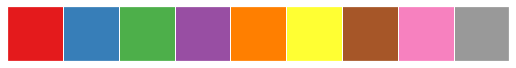

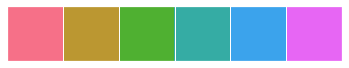

In [1]:
import numpy as np

import pandas as pd
#pd.set_option('display.max_columns', 30)                    # Display 30 columns for viewing purposes
#pd.options.display.float_format = '{:,.2f}'.format         # Reduce decimal points to 2

import datetime as dt
#import pandas_datareader.data as web

import statsmodels
# we will use `smf` and `sm` to constract and estimate same regressions but using different ways
import statsmodels.formula.api as smf  
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from linearmodels import PanelOLS, RandomEffects
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels.iv.results import compare

from collections import OrderedDict


from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')
sns.palplot(sns.color_palette("Set1"))
sns.palplot(sns.color_palette("husl"))
plt.rc("figure", figsize=(15, 10))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

In [2]:
df=pd.read_csv('data/caschool.csv')
df

,ObservationNumber,distCode,county,district,gr_span,enrlTot,teachers,calwPct,mealPct,computer,testscr,compStu,expnStu,str,avginc,elPct,readScr,mathScr
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024
3,4,61457,Butte,Golden Feather Union Elementary,KK-08,243,14.000000,36.475399,77.049202,85,647.700012,0.349794,7101.831055,17.357143,8.978000,0.000000,651.900024,643.500000
4,5,61523,Butte,Palermo Union Elementary,KK-08,1335,71.500000,33.108601,78.427002,171,640.849976,0.128090,5235.987793,18.671329,9.080333,13.857677,641.799988,639.900024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,416,68957,San Mateo,Las Lomitas Elementary,KK-08,984,59.730000,0.101600,3.556900,195,704.300049,0.198171,7290.338867,16.474134,28.716999,5.995935,700.900024,707.700012
416,417,69518,Santa Clara,Los Altos Elementary,KK-08,3724,208.479996,1.074100,1.503800,721,706.750000,0.193609,5741.462891,17.862625,41.734108,4.726101,704.000000,709.500000
417,418,72611,Ventura,Somis Union Elementary,KK-08,441,20.150000,3.563500,37.193802,45,645.000000,0.102041,4402.831543,21.885857,23.733000,24.263039,648.299988,641.700012
418,419,72744,Yuba,Plumas Elementary,KK-08,101,5.000000,11.881200,59.405899,14,672.200012,0.138614,4776.336426,20.200001,9.952000,2.970297,667.900024,676.500000


## OVB
Check if OVB conditions are satisfied  

$TestScr_i = \beta_0 + \beta_1 STR_i + \epsilon_i$ (possibly biased model due to omitted variable(s))  

vs.  

$TestScr_i = \gamma_0 + \gamma_1 STR_i + \gamma_2 ELpct_i + u_i$   

We check for: 
1. $Corr\left(ELpct,TestScr\right)\ne 0$
2. $Corr\left(ELpct,STR\right)\ne 0$

In [3]:
# Since 'corrcoef' returns a correlation matrix (size 2x2), get the off-diagonal element (at row 0 column 1)
np.corrcoef(df.elPct, df.str)[0,1]

0.1876423678544936

In [4]:
np.corrcoef(df.elPct, df.testscr)[0,1]

-0.6441237364147788

Given the sign of the product of the two correlation coefficients, the expected bias is negative. I this particular example, the estimated coefficient is lower than it should be.

In [5]:
reg = smf.ols('testscr ~ str', data=df).fit()
res_OLSommited = reg.summary()
res_OLSommited

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     22.58
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           2.78e-06
Time:                        20:55:33   Log-Likelihood:                -1822.2
No. Observations:                 420   AIC:                             3648.
Df Residuals:                     418   BIC:                             3657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    698.9330      9.467     73.825      0.000     680.323     717.543
str           -2.2798      0.480     -4.751      0.000      -3.223      -1.337
==============================================================================
Omnibus:                        5.390   Durbin-Watson:                   0.129
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                3.589
Skew:                          -0.012   Prob(JB):                        0.166
Kurtosis:                       2.548   Cond. No.                         207.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
reg = smf.ols('testscr ~ str + elPct', data=df).fit()
res_OLStrue = reg.summary()
res_OLStrue

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                testscr   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     155.0
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           4.62e-51
Time:                        20:55:39   Log-Likelihood:                -1716.6
No. Observations:                 420   AIC:                             3439.
Df Residuals:                     417   BIC:                             3451.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    686.0322      7.411     92.566      0.000     671.464     700.600
str           -1.1013      0.380     -2.896      0.004      -1.849      -0.354
elPct         -0.6498      0.039    -16.516      0.000      -0.727      -0.572
==============================================================================
Omnibus:                        0.631   Durbin-Watson:                   0.686
Prob(Omnibus):                  0.729   Jarque-Bera (JB):                0.550
Skew:                           0.088   Prob(JB):                        0.760
Kurtosis:                       3.024   Cond. No.                         301.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Advanced Example 1

### Importing data

The dataset comes from the Medical Expenditure Panel Survey (MEPS) and includes data on **out-of-pocket drug expenditure** (in logs), individual characteristics, whether an individual was insured through an employer or union (a likely endogenous variable), and some candidate instruments including the percentage of income from Social Security Income, the size of the individual's firm and whether the firm has multiple locations.


We analyze medical expenditures of individuals 65 years and older who qualify for health care under the U.S. Medicare program. Medicare does not cover all medical expenses. For example, co-payments for medical services and expenses of prescribed pharmaceutical drugs were not covered for the time period studied here. About half of eligible individuals therefore purchase supplementary insurance in the private market that provides insurance coverage against various out-of-pocket expenses.

We consider the impact of this supplementary insurance on total annual medical expenditures of an individual1 measured in dollars. A formal investigation must control for the influence of other factors that also determine individual medical expenditure, notably, socio-demographic factors such as age, gender, education and income, geographical location, and health-status measures such as self-assessed health and presence of chronic or limiting conditions. 

The equation to be estimated has the **dependent variable** `ldrugexp`, the log of total out-of-pocket expenditures on prescribed medications. The **regressors** are an indicator for whether the individual holds either employer or union-sponsored health insurance (`hi_empunion`), number of chronic conditions (`totchr`), and four socio-demographic variables: age in years (`age`), indicators for whether female (`female`) and whether black or Hispanic (`blhisp`), and the natural logarithm of annual household income in thousands of dollars (`linc`).

We treat the health insurance variable `hi_empunion` as *endogenous*. The intuitive justification is that having such supplementary insurance on top of the near universal Medicare insurance for the elderly may be a choice variable. Even though most individuals
in the sample are no longer working, those who expected high future medical expenses might have been more likely to choose a job when they were working that would provide supplementary health insurance upon retirement. Note that Medicare did not cover drug expenses for the time period we study.

In [7]:
from linearmodels.datasets import meps
data = meps.load()
data = data.dropna()
print(meps.DESCR)


age               Age
age2              Age-squared
black             Black
blhisp            Black or Hispanic
drugexp           Presc-drugs expense
educyr            Years of education
fair              Fair health
female            Female
firmsz            Firm size
fph               fair or poor health
good              Good health
hi_empunion       Insured thro emp/union
hisp              Hiapanic
income            Income
ldrugexp          log(drugexp)
linc              log(income)
lowincome         Low income
marry             Married
midincome         Middle income
msa               Metropolitan stat area
multlc            Multiple locations
poor              Poor health
poverty           Poor
priolist          Priority list cond
private           Private insurance
ssiratio          SSI/Income ratio
totchr            Total chronic cond
vegood            V-good health
vgh               vg or good health



Next the data – dependent, endogenous and controls – are summarized. The controls are grouped into a list to simplify model building.

In [11]:
#data.to_csv('meps.csv')

Around 38% of the sample has either employer or union-sponsored health insurance in addition to Medicare insurance:

In [8]:
sum(data.hi_empunion)/len(data.hi_empunion)

0.3821984339379522

We consider four potential instruments for `hi_empunion`. Two reflect the income status of the individual and two are based on employer characteristics.

- The `ssiratio` instrument is the ratio of an individual's social security income to the individual's income from all sources, with high values indicating a significant income constraint. 
- The `lowincome` instrument is a qualitative indicator of low-income status.

Both these instruments are likely to be relevant, because they are expected to be negatively correlated with having supplementary insurance. 

To be valid instruments we need to assume they can be omitted from the equation for `ldrugexp`, arguing that the direct role of income is adequately captured by the regressor `linc`.

- The `firmsz` instrument measures the size of the firm's employed labor force, and 
- the `multlc` instrument indicates whether the firm is a large operator with multiple locations. 

These variables are intended to capture whether the individual has access to supplementary insurance through the employer. These two variables are irrelevant for those who are retired, self-employed, or purchase insurance privately. In that sense, these two instruments could potentially be weak.

To conclude, we have four available instruments for one endogenous regressor. The obvious approach is to use all available instruments, because **in theory** this leads to the most efficient estimator. **In practice**, it may lead to larger small-sample bias because the small-sample biases of IV estimators increase with the number of instruments (Hahn and Hausman 2002).

In [9]:
controls = ['totchr', 'female', 'age', 'linc','blhisp']
instruments = ['ssiratio', 'lowincome', 'multlc', 'firmsz']
data[['ldrugexp','hi_empunion'] + controls + instruments].describe(percentiles=[])

,ldrugexp,hi_empunion,totchr,female,age,linc,blhisp,ssiratio,lowincome,multlc,firmsz
count,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000,10089.000000
mean,6.481361,0.382198,1.860938,0.577064,75.051740,2.743275,0.163544,0.536544,0.187432,0.062048,0.140529
std,1.362052,0.485949,1.292858,0.494050,6.682109,0.913143,0.369880,0.367818,0.390277,0.241254,2.170389
min,0.000000,0.000000,0.000000,0.000000,65.000000,-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.678342,0.000000,2.000000,1.000000,74.000000,2.743160,0.000000,0.504522,0.000000,0.000000,0.000000
max,10.180172,1.000000,9.000000,1.000000,91.000000,5.744476,1.000000,9.250620,1.000000,1.000000,50.000000


At a minimum, it is informative to use `corr()` to view the gross correlation between endogenous variables and instruments and between instruments. When multiple instruments are available, as in the case of overidentified models, then it is actually the
partial correlation after controlling for other available instruments that matters.

We check for the simple correlation between the endogenous variable and the instruments. Instruments must be correlated to be relevant (but also must be exogenous, which can't be examined using simple correlation). The correlation of `firmsz` is especially low, which might lead to the weak instruments problem if used exclusively.

In [10]:
data[['hi_empunion'] + instruments].corr()

,hi_empunion,ssiratio,lowincome,multlc,firmsz
hi_empunion,1.000000,-0.212431,-0.116419,0.119849,0.037352
ssiratio,-0.212431,1.000000,0.253946,-0.190433,-0.044578
lowincome,-0.116419,0.253946,1.000000,-0.062465,-0.008232
multlc,0.119849,-0.190433,-0.062465,1.000000,0.187275
firmsz,0.037352,-0.044578,-0.008232,0.187275,1.000000


In [11]:
from statsmodels.api import OLS, add_constant
# alternatively, add_constant from statsmodels is used to simplify the process of adding a constant column to the data.
data['const'] = 1
controls = ['const'] + controls
data

,ssiratio,age,educyr,drugexp,private,female,hisp,marry,vegood,good,...,totchr,black,hi_empunion,ldrugexp,age2,linc,vgh,fph,blhisp,const
0,0.149877,74,16,595,1,1,0,1,0,1,...,0,0,1,6.388561,5476.0,4.549085,1.0,0.0,0.0,1
1,0.395856,73,8,1783,1,0,0,1,0,1,...,3,0,1,7.486053,5329.0,3.577847,1.0,0.0,0.0,1
2,1.000000,80,12,176,0,1,0,0,0,0,...,1,0,0,5.170484,6400.0,2.261763,0.0,0.0,0.0,1
3,0.206639,70,17,2437,1,0,0,1,0,1,...,5,0,1,7.798523,4900.0,3.656221,1.0,0.0,0.0,1
4,0.537192,91,16,330,0,0,0,1,1,0,...,3,0,0,5.799093,8281.0,2.166193,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1.000000,83,6,2092,0,0,1,1,0,0,...,2,0,0,7.645876,6889.0,1.599388,0.0,0.0,1.0,1
10387,0.974529,72,9,9406,1,1,0,0,0,0,...,6,0,1,9.149103,5184.0,2.606018,0.0,0.0,0.0,1
10388,0.837477,80,13,8198,1,1,0,0,0,0,...,2,0,0,9.011645,6400.0,2.439125,0.0,1.0,0.0,1
10389,1.000000,67,3,1254,0,1,1,1,0,0,...,2,0,0,7.134094,4489.0,2.140066,0.0,0.0,1.0,1


## 2SLS as OLS

See: https://bashtage.github.io/linearmodels/iv/iv/linearmodels.iv.model.IV2SLS.html#linearmodels.iv.model.IV2SLS 
  
Estimation of IV models using two-stage least squares:  
`IV2SLS(dependent, exog, endog, instruments, *, weights=None)`  
- `dependent` (array-like) – Endogenous variables (nobs by 1)
- `exog` (array-like) – Exogenous regressors (nobs by nexog)
- `endog` (array-like) – Endogenous regressors (nobs by nendog)
- `instruments` (array-like) – Instrumental variables (nobs by ninstr)
- `weights` (array-like, optional) – Observation weights used in estimation

Before examining the IV estimators, it is worth noting that 2SLS nests the OLS estimator, so that a call to `IV2SLS` using `None` for the `endogenous` and `instruments` will produce OLS estimates of parameters.  

The OLS estimates indicate that insurance through an employer or union leads to an increase in out-of-pocket drug expenditure.

In [13]:
# Recall:      IV2SLS(dependent,               exog,                  endog, instruments, *, weights=None)
IV_OLS_model = IV2SLS(data.ldrugexp, data[['hi_empunion'] + controls], None, None)
IV_OLS_results = IV_OLS_model.fit()
IV_OLS_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.1770
Estimator:                        OLS   Adj. R-squared:                 0.1765
No. Observations:               10089   F-statistic:                    2262.6
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:11:29   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
hi_empunion     0.0739     0.0260     2.8441     0.0045      0.0230      0.1248
const           5.8611     0.1570     37.320     0.0000      5.5533      6.1689
totchr          0.4404     0.0094     47.049     0.0000      0.4220      0.4587
female          0.0578     0.0254     2.2797     0.0226      0.0081      0.1075
age            -0.0035     0.0019    -1.8228     0.0683     -0.0073      0.0003
linc            0.0105     0.0137     0.7646     0.4445     -0.0164      0.0373
blhisp         -0.1513     0.0341    -4.4353     0.0000     -0.2182     -0.0844
===============================================================================
"""

> <font color=DeepPink>Exercise</font>: <br>
> Interpret the estimated coefficient for `hi_empunion`.<br>
> Interpret all other estimates.

## Just identified 2SLS
The just identified two-stage LS estimator uses as many instruments as endogenous variables. In the following example there is one of each, using the SSI ratio as the instrument. The with the instrument, the effect of insurance through employer or union has a strong negative effect on drug expenditure.

Therefore, we begin with IV regression of `ldrugexp` on the endogenous regressor `hi_empunion`, instrumented by the single instrument `ssiratio`, and several exogenous regressors (defined in the list `controls` above).

In [14]:
# Recall:  IV2SLS(dependent,         exog,          endog,          instruments, *, weights=None)
IV_model = IV2SLS(data.ldrugexp, data[controls], data.hi_empunion, data.ssiratio)
IV_results = IV_model.fit()
IV_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0640
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0634
No. Observations:               10089   F-statistic:                    2000.9
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:12:11   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           6.7872     0.2688     25.246     0.0000      6.2602      7.3141
totchr          0.4503     0.0102     44.157     0.0000      0.4303      0.4703
female         -0.0204     0.0326    -0.6257     0.5315     -0.0843      0.0435
age            -0.0132     0.0030    -4.4092     0.0000     -0.0191     -0.0073
linc            0.0870     0.0226     3.8436     0.0001      0.0426      0.1314
blhisp         -0.2174     0.0395    -5.5052     0.0000     -0.2948     -0.1400
hi_empunion    -0.8976     0.2211    -4.0592     0.0000     -1.3310     -0.4642
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio
Robust Covariance (Heteroskedastic)
Debiased: False
"""

**Discussion**: Supplementary insurance has a big effect. The estimated coefficient of `hi_empunion` is ~0.898, indicating that supplementary-insured individuals have out-of-pocket drug expenses that are 90% lower than those for people without employment or union-related supplementary insurance.

*** 
<font color=red>**Tip**</font>: You can use the **formula notation** instead of separating the data into parts. 

The formulas used here utilize `patsy` are similar to those in `statsmodels`, although they use an enhanced syntax to allow identification of endogenous regressors. The basis formula syntax for a single variable regression would be 

> `y ~ 1 + x`

where the 1 indicates that a constant should be included and `x` is the regressor. 

In the context of an instrumental variables model, it is necessary to mark variables as endogenous and to provide a list of instruments that are included only in the model for the endogenous variables. In a basic single regressor model, this would be specified using `[ ]` to surround an inner model.

> `y ~ 1 + [x ~ z]`

In this expression, `x` is now marked as endogenous and `z` is an instrument. Any exogenous variable will automatically be used when instrumenting `x` so there is no need to repeat these here (in this example, the *"first stage"* would include a constant and `z`).

More on using formula-based notation including examples on multiple endogenous variables, see [here](https://bashtage.github.io/linearmodels/iv/examples/using-formulas.html).

In [15]:
formula = 'ldrugexp ~ 1 + totchr + female + age + linc + blhisp + [hi_empunion ~ ssiratio]'
mod = IV2SLS.from_formula(formula, data)
res = mod.fit(cov_type='robust')
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0640
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0634
No. Observations:               10089   F-statistic:                    2000.9
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:17:20   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       6.7872     0.2688     25.246     0.0000      6.2602      7.3141
age            -0.0132     0.0030    -4.4092     0.0000     -0.0191     -0.0073
blhisp         -0.2174     0.0395    -5.5052     0.0000     -0.2948     -0.1400
female         -0.0204     0.0326    -0.6257     0.5315     -0.0843      0.0435
linc            0.0870     0.0226     3.8436     0.0001      0.0426      0.1314
totchr          0.4503     0.0102     44.157     0.0000      0.4303      0.4703
hi_empunion    -0.8976     0.2211    -4.0592     0.0000     -1.3310     -0.4642
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio
Robust Covariance (Heteroskedastic)
Debiased: False
"""

***
## Multiple Instruments

Using multiple instruments only requires expanding the data array in the instruments input.

We next consider estimation of an **overidentified model**. Then different estimates are obtained by 2SLS estimation and by different variants of GMM.

We use two instruments, `ssiratio` and `multlc` for `hi_empunion`, the endogenous regressor. 

1. The first estimator is **2SLS**; obtained by using `IV2SLS` with standard errors that correct for heteroskedasticity with the `cov_type='robust'` option. 
2. The second estimator is the same as the first but reports default standard errors that do not adjust for heteroskedasticity, e.g., `cov_type='unadjusted'`
3. The third estimator is **optimal GMM** given heteroskedastic errors; obtained by using 'IVGMM' with the `robust` option. 
> Estimators in (1) and (3) are the two leading estimators for overidentified IV with cross-section data and no clustering of the errors. 
4. The fourth estimator is one that illustrates optimal **GMM with clustered errors** by clustering on `age`. E.g., `cov_type='clustered', clusters=data.age`
5. The final estimator adds igmm to iterate to convergence. 

In [16]:
# Recall:       IV2SLS(  dependent,         exog,          endog,              instruments,         *, weights=None)
IVmulti_model = IV2SLS(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
IVmulti_results = IVmulti_model.fit(cov_type='robust')
IVmulti_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0414
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0409
No. Observations:               10089   F-statistic:                    1955.4
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:20:40   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           6.8752     0.2579     26.660     0.0000      6.3697      7.3806
totchr          0.4512     0.0103     43.769     0.0000      0.4310      0.4714
female         -0.0278     0.0322    -0.8653     0.3869     -0.0909      0.0352
age            -0.0141     0.0029    -4.8753     0.0000     -0.0198     -0.0085
linc            0.0943     0.0219     4.3079     0.0000      0.0514      0.1372
blhisp         -0.2237     0.0396    -5.6514     0.0000     -0.3013     -0.1461
hi_empunion    -0.9899     0.2046    -4.8386     0.0000     -1.3909     -0.5889
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio, multlc
Robust Covariance (Heteroskedastic)
Debiased: False
"""

## Alternative covariance estimators

All estimator allow for the following types of parameter covariance estimator:

- `unadjusted` is the classic homoskedastic estimator
- `robust` (default) is robust to heteroskedasticity
- `clustered` allows one- or two-way clustering to account for additional sources of dependence between the model scores
- `kernel` produces a heteroskedasticity-autocorrelation robust covariance estimator

These are all passed using the keyword input cov_type. Using clustered requires also passing the clustering variable(s).

In [17]:
IVmulti_unadjusted_results = IVmulti_model.fit(cov_type='unadjusted')
IVmulti_unadjusted_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0414
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0409
No. Observations:               10089   F-statistic:                    1882.3
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:21:08   Distribution:                  chi2(6)
Cov. Estimator:            unadjusted                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           6.8752     0.2453     28.030     0.0000      6.3945      7.3559
totchr          0.4512     0.0105     42.942     0.0000      0.4306      0.4718
female         -0.0278     0.0312    -0.8933     0.3717     -0.0889      0.0332
age            -0.0141     0.0028    -5.0834     0.0000     -0.0196     -0.0087
linc            0.0943     0.0212     4.4400     0.0000      0.0527      0.1359
blhisp         -0.2237     0.0387    -5.7805     0.0000     -0.2996     -0.1479
hi_empunion    -0.9899     0.1922    -5.1501     0.0000     -1.3667     -0.6132
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio, multlc
Unadjusted Covariance (Homoskedastic)
Debiased: False
"""

## GMM Estimation

GMM estimation can be more efficient than 2SLS when there are **more than one instrument**. By default, 2-step efficient GMM is used (assuming the weighting matrix is correctly specified). It is possible to iterate until convergence using the optional keyword input `iter_limit`, which is naturally 2 by default. Generally, GMM-CUE would be preferred to using multiple iterations of standard GMM.  

The default weighting matrix is robust to heteroskecasticity (but not clustering).

In [18]:
IV_GMM_model =IVGMM(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
IV_GMM_results = IV_GMM_model.fit(cov_type='robust')
IV_GMM_results

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0406
Estimator:                     IV-GMM   Adj. R-squared:                 0.0400
No. Observations:               10089   F-statistic:                    1952.6
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:21:31   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           6.8778     0.2580     26.658     0.0000      6.3722      7.3835
totchr          0.4510     0.0103     43.738     0.0000      0.4307      0.4712
female         -0.0282     0.0322    -0.8752     0.3815     -0.0913      0.0349
age            -0.0142     0.0029    -4.8773     0.0000     -0.0198     -0.0085
linc            0.0945     0.0219     4.3142     0.0000      0.0515      0.1374
blhisp         -0.2231     0.0396    -5.6344     0.0000     -0.3007     -0.1455
hi_empunion    -0.9933     0.2047    -4.8530     0.0000     -1.3944     -0.5921
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio, multlc
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
IVGMMResults, id: 0x2417fb895b0

### Changing the weighting matrix structure in GMM estimation

The weighting matrix in the GMM objective function can be altered when creating the model. This example uses clustered weight by `age`. The covariance estimator should usually match the weighting matrix, and so clustering is also used here.

In [19]:
IV_GMM_clustered_model = IVGMM(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']],
                weight_type='clustered', clusters=data.age)
IV_GMM_clustered_results = IV_GMM_clustered_model.fit(cov_type='clustered', clusters=data.age)
IV_GMM_clustered_results

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0292
Estimator:                     IV-GMM   Adj. R-squared:                 0.0286
No. Observations:               10089   F-statistic:                    1700.8
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:21:40   Distribution:                  chi2(6)
Cov. Estimator:             clustered                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           6.7277     0.5059     13.299     0.0000      5.7362      7.7192
totchr          0.4482     0.0132     33.833     0.0000      0.4223      0.4742
female         -0.0245     0.0292    -0.8398     0.4010     -0.0817      0.0327
age            -0.0119     0.0063    -1.8928     0.0584     -0.0241      0.0004
linc            0.0957     0.0147     6.4934     0.0000      0.0668      0.1246
blhisp         -0.2091     0.0502    -4.1662     0.0000     -0.3074     -0.1107
hi_empunion    -1.0359     0.2044    -5.0683     0.0000     -1.4365     -0.6353
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio, multlc
GMM Covariance
Debiased: False
Clustered (One-way)
Num Clusters: 27
IVGMMResults, id: 0x2417fba7ac0

## Continuously updating GMM

The continuously updating GMM estimator simultaneously optimizes the moment conditions and the weighting matrix. It can be more efficient (in the second order sense) than standard 2-step GMM, although it can also be fragile. Here the optional input `display` is used to produce the output of the non-linear optimizer used to estimate the parameters.

In [20]:
IV_GMM_CUE_model = IVGMMCUE(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
IV_GMM_CUE_results = IV_GMM_CUE_model.fit(cov_type='robust', display=True)
IV_GMM_CUE_results

         Current function value: 1.045365
         Iterations: 10
         Function evaluations: 460
         Gradient evaluations: 56


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               ldrugexp   R-squared:                      0.0388
Estimator:                     IV-GMM   Adj. R-squared:                 0.0382
No. Observations:               10089   F-statistic:                    1949.2
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        21:21:50   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
const           6.8847     0.2583     26.657     0.0000      6.3785      7.3908
totchr          0.4510     0.0103     43.701     0.0000      0.4308      0.4712
female         -0.0288     0.0322    -0.8928     0.3720     -0.0919      0.0344
age            -0.0142     0.0029    -4.8969     0.0000     -0.0199     -0.0085
linc            0.0950     0.0219     4.3333     0.0000      0.0520      0.1380
blhisp         -0.2236     0.0396    -5.6421     0.0000     -0.3013     -0.1459
hi_empunion    -1.0002     0.2049    -4.8810     0.0000     -1.4019     -0.5986
===============================================================================

Endogenous: hi_empunion
Instruments: ssiratio, multlc
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
IVGMMResults, id: 0x2417fd414c0

## Comparing results

The function `compare` can be used to compare the results of multiple models, possibly with different variables, estimators and/or instruments. Usually a `dictionary` or `OrderedDict` is used to hold results since the keys are used as model names. The advantage of an `OrderedDict` is that it will preserve the order of the models in the presentation.

In [21]:
res = OrderedDict()
res['OLS'] = IV_OLS_results
res['2SLS'] = IV_results
res['2SLS-Multi-Homo'] = IVmulti_unadjusted_results
res['2SLS-Multi-Hetero'] = IVmulti_results
res['GMM'] = IV_GMM_results
res['GMM Cluster(Age)'] = IV_GMM_clustered_results
res['GMM-CUE'] = IV_GMM_CUE_results
compare(res)
#print(compare(res))

,OLS,2SLS,2SLS-Multi-Homo,2SLS-Multi-Hetero,GMM,GMM Cluster(Age),GMM-CUE
Dep. Variable,ldrugexp,ldrugexp,ldrugexp,ldrugexp,ldrugexp,ldrugexp,ldrugexp
Estimator,OLS,IV-2SLS,IV-2SLS,IV-2SLS,IV-GMM,IV-GMM,IV-GMM
No. Observations,10089,10089,10089,10089,10089,10089,10089
Cov. Est.,robust,robust,unadjusted,robust,robust,clustered,robust
R-squared,0.1770,0.0640,0.0414,0.0414,0.0406,0.0292,0.0388
Adj. R-squared,0.1765,0.0634,0.0409,0.0409,0.0400,0.0286,0.0382
F-statistic,2262.6,2000.9,1882.3,1955.4,1952.6,1700.8,1949.2
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
==================,===========,===========,============,===========,===========,===========,===========
hi_empunion,0.0739,-0.8976,-0.9899,-0.9899,-0.9933,-1.0359,-1.0002


**Discussion of results:** Compared with the just-identified IV estimates (Model name: *2SLS*), the parameter estimates in models including several instruments have changed by less than 10% (aside from those for the statistically insignificant regressor
female). The standard errors are little changed except for that for `hi_empunion` which has fallen by about 7% (observed via larger t-stats), reflecting efficiency gain due to additional instruments.

## Testing endogeneity
The **Durbin test** is a classic test of endogeneity which compares OLS estimates with 2SLS and exploits the fact that OLS estimates will be relatively efficient. Durbin's test is not robust to heteroskedasticity.  

The **Wu-Hausman test** (also called **Hausman specification test** or **Hausman test** or **Durbin–Wu–Hausman test**) is a variant of the Durbin test that uses a slightly different form. The test evaluates the consistency of an estimator when compared to an alternative, less efficient estimator which is already known to be consistent. It helps one evaluate if a statistical model corresponds to the data. 

The Hausman test principle provides a way to test whether a regressor is endogenous. 
- If there is little difference between OLS and IV estimators, then there is no need to instrument, and we conclude that the regressor was exogenous. 
- If instead there is considerable difference, then we needed to instrument and the regressor is endogenous.
The test usually compares just the coefficients of the endogenous variables. In the case of just one potentially endogenous regressor with a coefficient denoted by $\beta$, the Hausman test statistic
$$T_H=\frac{\left(\hat{\beta}_{IV} - \hat{\beta}_{OLS} \right)^2}{{Var}\left(\hat{\beta}_{IV} - \hat{\beta}_{OLS} \right)}$$
is $\chi^2\left(1\right)$ distributed under the null hypothesis that the regressor is exogenous.

> The Hausman test can be used to differentiate between fixed effects model and random effects model in panel analysis. In this case, Random effects (RE) is preferred under the null hypothesis due to higher efficiency, while under the alternative Fixed effects (FE) is at least as consistent and thus preferred. 


In [22]:
IV_results.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 25.2819
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x2417f101d00

In [23]:
IV_results.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 25.3253
P-value: 0.0000
Distributed: F(1,10081)
WaldTestStatistic, id: 0x2417f0b7370

### Confirm Hausman test statistic manually (...and see how it works)

The test statistic can be directly replicated using the squared $t$-stat in a 2-stage approach where

1. the first stage regresses the endogenous variable on the controls and instrument and 
2. the second stage regresses the dependent variable on the controls, the endogenous regressor and the residuals. 

If the regressor was in fact exogenous, the residuals should not be correlated with the dependent variable.

In [31]:
# Recall:
pd.concat([data[['hi_empunion'] + controls], resids], axis=1)

,hi_empunion,const,totchr,female,age,linc,blhisp,residual
0,1,1,0,1,74,4.549085,0.0,0.491839
1,1,1,3,0,73,3.577847,0.0,0.465539
2,0,1,1,1,80,2.261763,0.0,-0.195541
3,1,1,5,0,70,3.656221,0.0,0.374014
4,0,1,3,0,91,2.166193,0.0,-0.283677
...,...,...,...,...,...,...,...,...
10386,0,1,2,0,83,1.599388,1.0,-0.161146
10387,1,1,6,1,72,2.606018,0.0,0.649927
10388,0,1,2,1,80,2.439125,0.0,-0.248057
10389,0,1,2,1,67,2.140066,1.0,-0.251979


In [33]:
# regresses the endogenous variable on the controls and instrument; get residuals from this regression
step1 = IV2SLS(data.hi_empunion, data[['ssiratio'] + controls], None, None).fit()
resids = step1.resids

# regresses the dependent variable on the controls, the endogenous regressor and the residuals
exog = pd.concat([data[['hi_empunion'] + controls], resids], axis=1)
step2 = IV2SLS(data.ldrugexp, exog, None, None).fit(cov_type='unadjusted')

print(step2.tstats.residual **2)

25.34541049974769


Wooldridge’s regression-based test of exogeneity is robust to heteroskedasticity since it inherits the covariance estimator from the model. Here there is little difference.

In [25]:
IV_results.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 26.4542
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x241060ec8e0

Wooldridge’s score test is an alternative to the regression test, although it usually has slightly less power since it is an LM rather than a Wald type test.

In [26]:
IV_results.wooldridge_score

Wooldridge's score test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 24.9350
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x241060ecbb0

## Testing Exogeneity 

When there is more than one instrument (the model is overidentified), the J test can be used in GMM models to test whether the model is overidentified – in other words, whether the instruments are actually exogenous (assuming they are relevant). In the case with 2 instruments there is no evidence that against the null.


In [34]:
IV_GMM_results.j_stat

H0: Expected moment conditions are equal to 0
Statistic: 1.0475
P-value: 0.3061
Distributed: chi2(1)
WaldTestStatistic, id: 0x2417fb83ee0

When all instruments are included the story changes, and some of the additional instrument (`lowincome` or `firmsz`) appear to be endogenous.

In [35]:
IV_GMM_all_model = IVGMM(data.ldrugexp, data[controls], data.hi_empunion, data[instruments])
IV_GMM__all_results = IV_GMM_all_model.fit()
IV_GMM__all_results.j_stat

H0: Expected moment conditions are equal to 0
Statistic: 11.5903
P-value: 0.0089
Distributed: chi2(3)
WaldTestStatistic, id: 0x241062cf940

## Single Instrument Regressions

It can be useful to run the just identified regressions to see **how the IV estimate varies by instrument**. The OLS model is included for comparison. The coefficient when using `lowincome` is very similar to the OLS as is the $R^2$ which indicates this variable may be endogenous. The coefficient using `firmsz` is also very different, but this is probably due to the low correlation between `firmsz` and the endogenous regressor so that this is a weak instrument.

In [39]:
# Recall our definition of variable "instruments" above:
instruments

['ssiratio', 'lowincome', 'multlc', 'firmsz']

In [40]:
od = OrderedDict()

od['OLS'] = IV_OLS_results

for col in instruments:
    od[col] = IV2SLS(data.ldrugexp, data[controls], data.hi_empunion, data[col]).fit(cov_type='robust')

compare(od)

,OLS,ssiratio,lowincome,multlc,firmsz
Dep. Variable,ldrugexp,ldrugexp,ldrugexp,ldrugexp,ldrugexp
Estimator,OLS,IV-2SLS,IV-2SLS,IV-2SLS,IV-2SLS
No. Observations,10089,10089,10089,10089,10089
Cov. Est.,robust,robust,robust,robust,robust
R-squared,0.1770,0.0640,0.1768,-0.0644,-0.9053
Adj. R-squared,0.1765,0.0634,0.1763,-0.0651,-0.9064
F-statistic,2262.6,2000.9,2250.6,1734.1,950.64
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000
==================,===========,===========,===========,===========,===========
hi_empunion,0.0739,-0.8976,0.1170,-1.3459,-2.9323


## First Stage Diagnostics

First stage diagnostics are available to assess whether the instruments appear to be credible for the endogenous regressor. The Partial $F$-statistic is the $F$-statistic for all instruments once controls have been partialed out. In the case of a single instrument, it is just the squared $t$-stat.

In [45]:
IV_results.first_stage

,hi_empunion
R-squared,0.0761
Partial R-squared,0.0179
Shea's R-squared,0.0179
Partial F-statistic,65.806
P-value (Partial F-stat),4.441e-16
Partial F-stat Distn,chi2(1)
==========================,===========
const,1.0290
,(17.705)
totchr,0.0128


The $F$-statistic actually has a $\chi^2$ distribution since it is just a Wald test that all of the coefficients are 0. This breaks the “rule-of-thumb” but it can be applied by dividing the $F$-stat by the number of instruments.

In [46]:
IV_GMM_all_model = IV2SLS(data.ldrugexp, data[controls], data.hi_empunion, data[instruments])
IV_GMM_all_results = IV_GMM_all_model.fit()
IV_GMM_all_results.first_stage

,hi_empunion
R-squared,0.0821
Partial R-squared,0.0243
Shea's R-squared,0.0243
Partial F-statistic,179.47
P-value (Partial F-stat),0.0000
Partial F-stat Distn,chi2(4)
==========================,===========
const,0.9899
,(16.959)
totchr,0.0133


## Limited Information Maximum Likelihood (LIML)

Limited Information Maximum Likelihood (LIML) is a form of instrumental variable estimation that is quite similar to TSLS. As with TSLS, LIML uses instruments to rectify the problem where one or more of the right hand side variables in the regression are correlated with residuals.

LIML was first introduced by Anderson and Rubin (1949), prior to the introduction of two-stage least squares. However **traditionally TSLS has been favored by researchers over LIML as a method of instrumental variable estimation**. If the equation is exactly identified, LIML and TSLS will be numerically identical. Recent studies (for example, Hahn and Inoue 2002) have, however, found that **LIML performs better than TSLS in situations where there are many "weak" instruments**.

The LIML estimator and related $k$-class estimators can be used through `IVLIML`. LIML can have better finite sample properties if the model is not strongly identified. By default the $\kappa$ parameter is estimated. In this dataset it is very close to 1 and the results for LIML are similar to 2SLS (they would be exact if $\kappa=1$).



In [41]:
IV_LIML_model = IVLIML(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
IV_LIML_results = IV_LIML_model.fit(cov_type='robust')

compare({'2SLS':IVmulti_results,'LIML': IV_LIML_results, 'GMM': IV_GMM_results})

,2SLS,LIML,GMM
Dep. Variable,ldrugexp,ldrugexp,ldrugexp
Estimator,IV-2SLS,IV-LIML,IV-GMM
No. Observations,10089,10089,10089
Cov. Est.,robust,robust,robust
R-squared,0.0414,0.0400,0.0406
Adj. R-squared,0.0409,0.0394,0.0400
F-statistic,1955.4,1952.3,1952.6
P-value (F-stat),0.0000,0.0000,0.0000
==================,===========,===========,===========
const,6.8752,6.8807,6.8778


The estimated value of $\kappa$:

In [42]:
IV_LIML_results.kappa

1.0001153166806427

***
## Advanced Example 2

The file `schooling.csv` contain data taken from the National Longitudinal Survey of Young Men (NLSYM) concerning the United States. The analysis focusses on 1976 but uses some variables that date back to earlier years. The following variables available (many are dummy variables):
- smsa66      1 if lived in smsa in 1966
- smsa76      1 if lived in smsa in 1976
- nearc2      grew up near 2-yr college
- nearc4      grew up near 4-yr college
- nearc4a     grew up near 4-year public college
- nearc4b     grew up near 4-year private college
- ed76        education in 1976
- ed66        education in 1966
- age76       age in 1976
- daded       dads education (imputed avg if missing)
- nodaded     1 if dads education imputed
- momed       mothers education
- nomomed     1 if moms education imputed
- momdad14    1 if lived with mom and dad at age 14
- sinmom14    1 if single mom at age 14
- step14      1 if step parent at age 14
- south66     1 if lived in south in 1966
- south76     1 if lived in south in 1976
- lwage76     log wage in 1976 (outliers trimmed)
- famed       mom-dad education class (1-9)
- black       1 if black
- wage76      wage in 1976 (raw, cents per hour)
- enroll76    1 if enrolled in 1976
- kww         the kww score
- iqscore     a normed IQ score
- mar76       marital status in 1976 (1 if married)
- libcrd14    1 if library card in home at age 14
- exp76       experience in 1976
- exp762      exp76 squared

It is quite clear that, on average, people with more education have higher wages. It is less clear, however, whether this positive correlation reflects a causal effect of schooling, or that individuals with a greater earnings capacity have chosen more years of schooling. If the latter possibility is true, the OLS estimates on the returns to schooling simply reflect differences in unobserved characteristics of working individuals, and an increase in a person’s schooling owing to an exogenous shock will have no effect on this person’s wage.  

There are different reasons why schooling may be correlated with error term. However, if we can think of a variable that affects schooling but not wages, this variable can be used as IV. Typically, an instrument is thought of as a variable that affects the costs of schooling (and thus the choice of schooling) but not earnings. There is a long tradition of using family background variables, for example the number of siblings or parents' education, as instruments.  

In [45]:
df=pd.read_csv('data/schooling.csv')
df['const'] = 1                    # add a constant to your DataFrame
df['age76sqr'] = df['age76']**2    # add age^2 to your DataFrame
df

,smsa66,id,nearc2,nearc4,nearc4a,nearc4b,ed76,ed66,age76,daded,...,kww,iqscore,mar76,libcrd14,region,exp76,exp762,_merge,const,age76sqr
0,1,2,0,0,0,0,7,5,29,9.94,...,15.0,NaN,1.0,0.0,1,16,256,3,1,841
1,1,3,0,0,0,0,12,11,27,8.00,...,35.0,93.0,1.0,1.0,1,9,81,3,1,729
2,1,4,0,0,0,0,12,12,34,14.00,...,42.0,103.0,1.0,1.0,1,16,256,3,1,1156
3,1,5,1,1,1,0,11,11,27,11.00,...,25.0,88.0,1.0,1.0,2,10,100,3,1,729
4,1,6,1,1,1,0,12,12,34,8.00,...,34.0,108.0,1.0,0.0,2,16,256,3,1,1156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,0,5218,0,1,1,0,12,8,25,8.00,...,15.0,NaN,1.0,0.0,6,7,49,3,1,625
3006,0,5219,0,1,1,0,13,12,34,9.94,...,43.0,NaN,1.0,1.0,6,15,225,3,1,1156
3007,0,5220,0,1,1,0,12,9,24,11.00,...,25.0,109.0,1.0,0.0,6,6,36,3,1,576
3008,0,5221,0,1,1,0,12,12,31,9.94,...,32.0,107.0,1.0,1.0,6,13,169,3,1,961


In [46]:
IV_OLS_model = IV2SLS(df.lwage76, df[['const','ed76','exp76','exp762','black','smsa76','south76']], None, None)
IV_OLS_results = IV_OLS_model.fit()
IV_OLS_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                lwage76   R-squared:                      0.2905
Estimator:                        OLS   Adj. R-squared:                 0.2891
No. Observations:                3010   F-statistic:                    1309.5
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        22:30:32   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.7337     0.0701     67.550     0.0000      4.5963      4.8710
ed76           0.0740     0.0036     20.344     0.0000      0.0669      0.0811
exp76          0.0836     0.0067     12.431     0.0000      0.0704      0.0968
exp762        -0.0022     0.0003    -7.0525     0.0000     -0.0029     -0.0016
black         -0.1896     0.0174    -10.891     0.0000     -0.2238     -0.1555
smsa76         0.1614     0.0152     10.650     0.0000      0.1317      0.1911
south76       -0.1249     0.0153    -8.1434     0.0000     -0.1549     -0.0948
==============================================================================
"""

If schooling is endogenous, then experience and its square are by construction also endogenous, given that age is not a choice variable and therefore unambiguously exogenous. This means that **our linear model may suffer from three endogenous regressors so that we need (at least) three instruments**. For experience and its square, age and age-squared are obvious candidates. As discussed previously, for schooling the solution is less trivial.  

It is argued that the presence of a nearby college in 1966 may provide a valid instrument. A necessary (but not sufficient) condition for this is that college proximity in 1966 affects the schooling variable, conditional upon the other exogenous variables. To see whether this is the case, we estimate a reduced form, where schooling is explained by age and age-squared, the three dummy variables from the wage equation and a dummy indicating whether an individual lived near a college in 1966.

In [47]:
IV_OLS_model2 = IV2SLS(df.ed76, df[['const','age76','age76sqr','black','smsa76','south76','nearc4']], None, None)
IV_OLS_results2 = IV_OLS_model2.fit()
IV_OLS_results2.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                   ed76   R-squared:                      0.1185
Estimator:                        OLS   Adj. R-squared:                 0.1168
No. Observations:                3010   F-statistic:                    369.17
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        22:32:02   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -1.8695     4.2076    -0.4443     0.6568     -10.116      6.3771
age76          1.0614     0.2960     3.5858     0.0003      0.4813      1.6416
age76sqr      -0.0188     0.0052    -3.6384     0.0003     -0.0289     -0.0087
black         -1.4684     0.1153    -12.740     0.0000     -1.6943     -1.2425
smsa76         0.8354     0.1122     7.4431     0.0000      0.6154      1.0554
south76       -0.4597     0.1029    -4.4678     0.0000     -0.6614     -0.2580
nearc4         0.3471     0.1084     3.2011     0.0014      0.1346      0.5596
==============================================================================
"""

The fact that the lived near college dummy is significant in this reduced form is reassuring. It indicates that, ceteris paribus, students who lived near a college in 1966 have on average 0.3471 years more schooling. Recall that a valid instrument is required to be exogenous and relevant. Relevance requires that the candidate instrument is correlated with schooling but not a linear combination of the other variables of the model.  

Using age, age-squared and the lived near college dummy as instruments for experience, experience-squared and schooling, we obtain the estimation results reported below:

In [48]:
# dependent: lwage76
# endogenous: ed75, exp76, exp762
# instruments: age76, age76sqr, nearc4
# controls: black, smsa76, south76

IV_model = IV2SLS(df.lwage76, df[['const','black','smsa76','south76']], 
                  df[['ed76','exp76','exp762']], df[['age76', 'age76sqr', 'nearc4']])
IV_results = IV_model.fit()
IV_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                lwage76   R-squared:                      0.1764
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1747
No. Observations:                3010   F-statistic:                    980.21
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        22:33:43   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.0657     0.5990     6.7873     0.0000      2.8916      5.2397
black         -0.1031     0.0753    -1.3691     0.1710     -0.2508      0.0445
smsa76         0.1080     0.0493     2.1890     0.0286      0.0113      0.2047
south76       -0.0982     0.0284    -3.4568     0.0005     -0.1538     -0.0425
ed76           0.1329     0.0506     2.6248     0.0087      0.0337      0.2322
exp76          0.0560     0.0259     2.1633     0.0305      0.0053      0.1067
exp762        -0.0008     0.0013    -0.5999     0.5486     -0.0034      0.0018
==============================================================================

Endogenous: ed76, exp76, exp762
Instruments: age76, age76sqr, nearc4
Robust Covariance (Heteroskedastic)
Debiased: False
"""

The estimated returns to schooling are over 13%, with a relatively large standard error of somewhat more than 5%. Although the estimate is substantially higher than the OLS one, its inaccuracy is such that this difference could just be due to sampling error. Nevertheless, the value of the IV estimate is fairly robust to changes in the specification (e.g. the inclusion of regional indicators or family background variables). The fact that the IV estimator suffers from such large standard errors is due to the fairly low correlation between the instruments and the endogenous regressors. This is reflected in the $R^2$ of the reduced form for schooling, which is only 0.1185. Although in general the instrumental variables estimator is less accurate than the OLS estimator (which may be inconsistent), the loss in efficiency is particularly large if the instruments are only weakly correlated with the endogenous regressors.  

**Note**: some methods do not report any goodness-of-fit statistics. The reason is that there is no unique definition of an $R^2$ or $Adj\ R^2$ if the model is not estimated by ordinary least squares. More importantly, the fact that we estimate the model by instrumental variables methods indicates that goodness-of-fit is not what we are after. Our goal was to obtain a consistent estimator for the causal effect of schooling upon earnings, and that is exactly what instrumental variables methods are trying to do. Again, this reflects that the $R^2$ plays no role whatsoever in comparing alternative estimators.  

If college proximity is to be a valid instrument for schooling, it has to be the case that it has no direct effect on earnings. 


In [49]:
IV_GMM_model = IVGMM(df.lwage76, df[['const','black','smsa76','south76']], 
                  df[['ed76','exp76','exp762']], df[['age76', 'age76sqr', 'nearc4']])
IV_GMM_results = IV_GMM_model.fit()
IV_GMM_results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                lwage76   R-squared:                      0.1764
Estimator:                     IV-GMM   Adj. R-squared:                 0.1747
No. Observations:                3010   F-statistic:                    980.21
Date:                Tue, Mar 08 2022   P-value (F-stat)                0.0000
Time:                        22:34:18   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.0657     0.5990     6.7873     0.0000      2.8916      5.2397
black         -0.1031     0.0753    -1.3691     0.1710     -0.2508      0.0445
smsa76         0.1080     0.0493     2.1890     0.0286      0.0113      0.2047
south76       -0.0982     0.0284    -3.4568     0.0005     -0.1538     -0.0425
ed76           0.1329     0.0506     2.6248     0.0087      0.0337      0.2322
exp76          0.0560     0.0259     2.1633     0.0305      0.0053      0.1067
exp762        -0.0008     0.0013    -0.5999     0.5486     -0.0034      0.0018
==============================================================================

Endogenous: ed76, exp76, exp762
Instruments: age76, age76sqr, nearc4
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

In [50]:
compare({'OLS':IV_OLS_results,'2SLS': IV_results,'GMM': IV_GMM_results})

,OLS,2SLS,GMM
Dep. Variable,lwage76,lwage76,lwage76
Estimator,OLS,IV-2SLS,IV-GMM
No. Observations,3010,3010,3010
Cov. Est.,robust,robust,robust
R-squared,0.2905,0.1764,0.1764
Adj. R-squared,0.2891,0.1747,0.1747
F-statistic,1309.5,980.21,980.21
P-value (F-stat),0.0000,0.0000,0.0000
==================,===========,===========,===========
const,4.7337,4.0657,4.0657
